# Baseline Classifier with LightGBM

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

# Load the dataset
df = pd.read_csv('dataset.csv')

# Split features and labels
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values  # Already encoded (1 to 5)

# Normalize features (L2 norm)
X = Normalizer(norm='l2').fit_transform(X)

# Train-test split (80/20 stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)



In [4]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize LGBM model
lgbm = LGBMClassifier(
    #n_estimators=300,
    #learning_rate=0.05,
    #num_leaves=64,
    #max_depth=-1,
    #random_state=42,
    #n_jobs=-1,
    verbose=-1
)

# Train
lgbm.fit(X_train, y_train)

# Predict
y_pred = lgbm.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9461206896551724
Classification Report:
               precision    recall  f1-score   support

           1     0.8803    0.9084    0.8941       251
           2     0.9533    0.9238    0.9383       420
           3     0.9835    0.9910    0.9872       781
           4     0.9252    0.9234    0.9243       509
           5     0.9331    0.9331    0.9331       359

    accuracy                         0.9461      2320
   macro avg     0.9351    0.9359    0.9354      2320
weighted avg     0.9463    0.9461    0.9461      2320

Confusion Matrix:
 [[228   4   1  13   5]
 [  8 388   8  11   5]
 [  1   4 774   0   2]
 [ 18   7   2 470  12]
 [  4   4   2  14 335]]


In [25]:
import joblib

# Save model
joblib.dump(lgbm, 'lgbm_baseline_model.pkl')

# Save data splits for consistent evaluation later
np.savez('dataset_split.npz', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)



# Semi-Supervised Pipeline

In [5]:
# 🧪 Step 1: Data Prep
import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
from lightgbm import LGBMClassifier

# Load dataset
df = pd.read_csv("feature_vectors_syscallsbinders_frequency_5_Cat.csv")
X = df.drop(columns=["Class"]).values
y = df["Class"].values - 1  # Convert labels from 1–5 to 0–4

# Test set: 30%
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Save test set for adversarial evaluation
np.savez('dataset_split.npz', X_test=X_test, y_test=y_test)

# Labeled: 20%, Unlabeled: 80% of the remaining
X_lab, X_unlab, y_lab, _ = train_test_split(X_dev, y_dev, test_size=0.8, stratify=y_dev, random_state=42)

# Standardize
scaler = StandardScaler()
X_lab = scaler.fit_transform(X_lab)
X_unlab = scaler.transform(X_unlab)
X_test = scaler.transform(X_test)

# 🧠 Step 2: Train LGBM on Labeled Set

lgbm = LGBMClassifier(
    #n_estimators=300,
    #learning_rate=0.05,
    #num_leaves=64,
    #max_depth=-1,
    #random_state=42,
    #n_jobs=-1,
    verbose=-1
)

lgbm.fit(X_lab, y_lab)

# Evaluate baseline LGBM trained on labeled data only
y_pred_supervised = lgbm.predict(X_test)

acc_supervised = accuracy_score(y_test, y_pred_supervised)
f1_supervised = f1_score(y_test, y_pred_supervised, average='macro')
report_supervised = classification_report(
    y_test, y_pred_supervised,
    target_names=['Adware', 'Banking', 'SMS', 'Riskware', 'Benign'],
    digits=4
)

print("==LGBM Supervised Only Evaluation ==")
print(f"Accuracy: {acc_supervised:.4f}")
print(f"Macro F1-score: {f1_supervised:.4f}")
print("Classification Report:\n", report_supervised)


# 🏷️ Step 3: Generate Pseudo-labels

# Predict on unlabeled
probs = lgbm.predict_proba(X_unlab)
pseudo_labels = np.argmax(probs, axis=1)
confidences = np.max(probs, axis=1)

# Select confident predictions
threshold = 0.70
mask = confidences >= threshold
X_pseudo = X_unlab[mask]
y_pseudo = pseudo_labels[mask]

print(f"Selected {len(X_pseudo)} pseudo-labeled samples out of {len(X_unlab)}")

# 🔁 Step 4: Combine and Retrain

# Combine labeled + pseudo-labeled
X_combined = np.vstack([X_lab, X_pseudo])
y_combined = np.hstack([y_lab, y_pseudo])

# Retrain LGBM
lgbm_ssl = LGBMClassifier(
    n_estimators=400,
    learning_rate=0.05, # 0.05
    #num_leaves=64,
    #max_depth=-1,
    #random_state=42,
    #n_jobs=-1,
    verbose=-1
)
lgbm_ssl.fit(X_combined, y_combined)

# joblib.dump(lgbm_ssl, 'lgbm_baseline_model.pkl')

# 📊 Step 5: Final Evaluation on Test Set

y_pred = lgbm_ssl.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
report = classification_report(
    y_test, y_pred,
    target_names=['Adware', 'Banking', 'SMS', 'Riskware', 'Benign'],
    digits=4
)

print("== LGBM Semi-Supervised Evaluation ==")
print(f"Accuracy: {acc:.4f}")
print(f"Macro F1-score: {f1:.4f}")
print("Classification Report:\n", report)

==LGBM Supervised Only Evaluation ==
Accuracy: 0.9172
Macro F1-score: 0.9008
Classification Report:
               precision    recall  f1-score   support

      Adware     0.8222    0.8484    0.8351       376
     Banking     0.9002    0.8873    0.8937       630
         SMS     0.9616    0.9829    0.9721      1171
    Riskware     0.9385    0.8796    0.9081       764
      Benign     0.8799    0.9109    0.8952       539

    accuracy                         0.9172      3480
   macro avg     0.9005    0.9018    0.9008      3480
weighted avg     0.9177    0.9172    0.9171      3480

Selected 6243 pseudo-labeled samples out of 6495
== LGBM Semi-Supervised Evaluation ==
Accuracy: 0.9230
Macro F1-score: 0.9089
Classification Report:
               precision    recall  f1-score   support

      Adware     0.8317    0.8803    0.8553       376
     Banking     0.9255    0.8873    0.9060       630
         SMS     0.9624    0.9829    0.9725      1171
    Riskware     0.9339    0.8874    0.910

# Random Feature Dropout

In [8]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

# === Define perturbation function ===
def randomly_zero_features(X, drop_ratio, seed=None):
    rng = np.random.default_rng(seed)
    X_perturbed = X.copy()
    n_samples, n_features = X.shape
    n_drop = int(n_features * drop_ratio)

    for i in range(n_samples):
        drop_indices = rng.choice(n_features, n_drop, replace=False)
        X_perturbed[i, drop_indices] = 0.0

    return X_perturbed

# === Run robustness evaluation ===
drop_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
results = []

for drop_ratio in drop_levels:
    X_perturbed = randomly_zero_features(X_test, drop_ratio, seed=42)
    y_pred = lgbm_ssl.predict(X_perturbed)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    results.append((drop_ratio, acc, f1))

    print(f"Drop {int(drop_ratio * 100)}% | Accuracy: {acc:.4f} | Macro F1: {f1:.4f}")


Drop 0% | Accuracy: 0.9230 | Macro F1: 0.9089
Drop 10% | Accuracy: 0.8546 | Macro F1: 0.8443
Drop 20% | Accuracy: 0.7230 | Macro F1: 0.7246
Drop 30% | Accuracy: 0.5874 | Macro F1: 0.5930
Drop 40% | Accuracy: 0.4983 | Macro F1: 0.5036
Drop 50% | Accuracy: 0.4325 | Macro F1: 0.4320


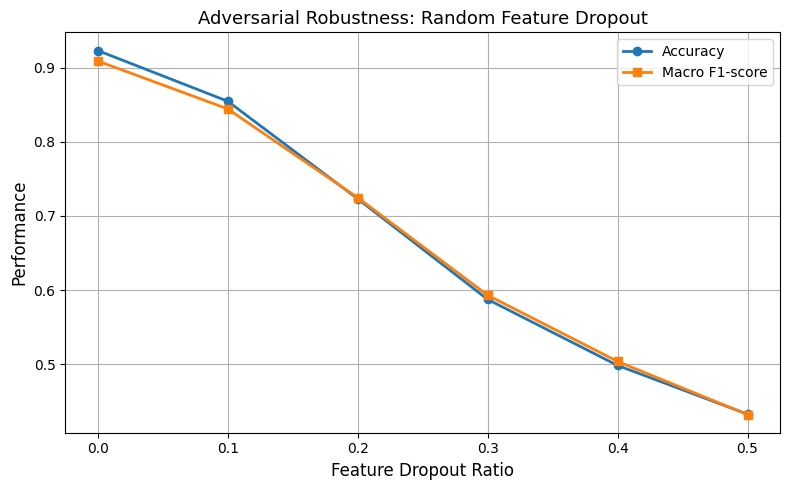

In [9]:
# === Plot accuracy and macro F1 drop ===
ratios, accs, f1s = zip(*results)

plt.figure(figsize=(8, 5))
plt.plot(ratios, accs, marker='o', label='Accuracy', linewidth=2)
plt.plot(ratios, f1s, marker='s', label='Macro F1-score', linewidth=2)
plt.xlabel('Feature Dropout Ratio', fontsize=12)
plt.ylabel('Performance', fontsize=12)
plt.title('Adversarial Robustness: Random Feature Dropout', fontsize=13)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Confusion Matrices Under Feature Dropout

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

class_names = ['Adware', 'Banking', 'SMS', 'Riskware', 'Benign']

def plot_confusion(cm, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.tight_layout()
    plt.show()


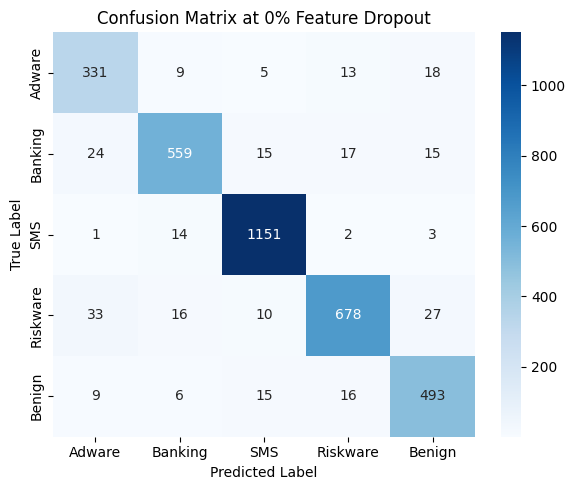

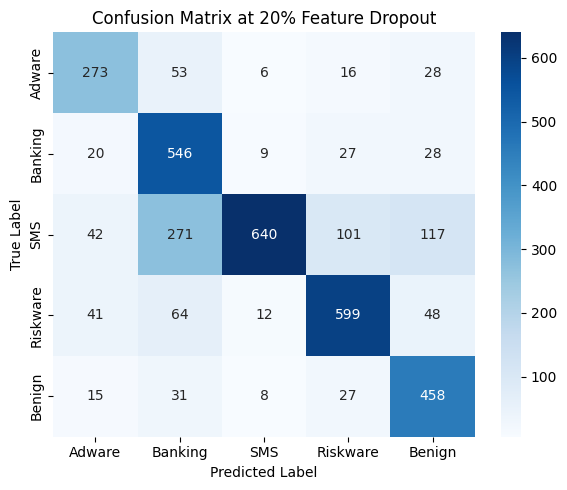

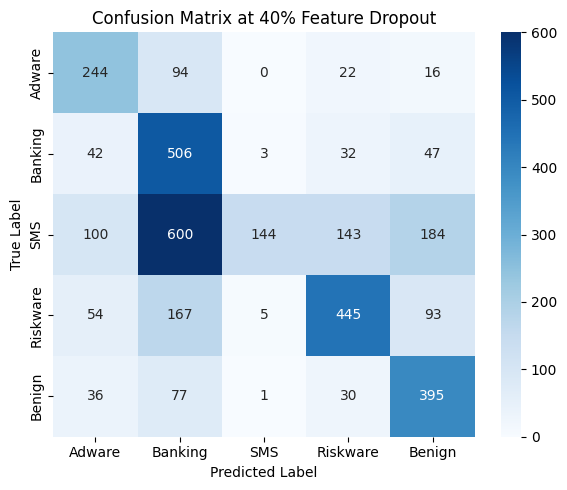

In [11]:
drop_levels = [0.0, 0.2, 0.4]

for drop_ratio in drop_levels:
    X_perturbed = randomly_zero_features(X_test, drop_ratio, seed=42)
    y_pred = lgbm_ssl.predict(X_perturbed)
    
    cm = confusion_matrix(y_test, y_pred)
    title = f"Confusion Matrix at {int(drop_ratio * 100)}% Feature Dropout"
    plot_confusion(cm, title)


In [12]:
from sklearn.metrics import confusion_matrix

class_names = ['Adware', 'Banking', 'SMS', 'Riskware', 'Benign']
drop_levels = [0.0, 0.2, 0.4]

for drop_ratio in drop_levels:
    X_perturbed = randomly_zero_features(X_test, drop_ratio, seed=42)
    y_pred = lgbm_ssl.predict(X_perturbed)
    
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix at {int(drop_ratio * 100)}% Feature Dropout:")
    print(cm)



Confusion Matrix at 0% Feature Dropout:
[[ 331    9    5   13   18]
 [  24  559   15   17   15]
 [   1   14 1151    2    3]
 [  33   16   10  678   27]
 [   9    6   15   16  493]]

Confusion Matrix at 20% Feature Dropout:
[[273  53   6  16  28]
 [ 20 546   9  27  28]
 [ 42 271 640 101 117]
 [ 41  64  12 599  48]
 [ 15  31   8  27 458]]

Confusion Matrix at 40% Feature Dropout:
[[244  94   0  22  16]
 [ 42 506   3  32  47]
 [100 600 144 143 184]
 [ 54 167   5 445  93]
 [ 36  77   1  30 395]]


# Epsilon noise attacks (simple uniform perturbation)

In [13]:
def add_uniform_noise(X, epsilon=0.1, seed=None):
    rng = np.random.default_rng(seed)
    noise = rng.uniform(low=-epsilon, high=epsilon, size=X.shape)
    return X + noise
epsilons = [0.0, 0.05, 0.1, 0.2, 0.3]
print("🔬 Epsilon Noise Attack Results:\n")

for eps in epsilons:
    X_adv = add_uniform_noise(X_test, epsilon=eps, seed=42)
    y_pred = lgbm_ssl.predict(X_adv)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    
    print(f"Epsilon = {eps:.2f} | Accuracy: {acc:.4f} | Macro F1: {f1:.4f}")


🔬 Epsilon Noise Attack Results:

Epsilon = 0.00 | Accuracy: 0.9230 | Macro F1: 0.9089
Epsilon = 0.05 | Accuracy: 0.5598 | Macro F1: 0.5507
Epsilon = 0.10 | Accuracy: 0.4356 | Macro F1: 0.4222
Epsilon = 0.20 | Accuracy: 0.3511 | Macro F1: 0.3331
Epsilon = 0.30 | Accuracy: 0.3167 | Macro F1: 0.2974


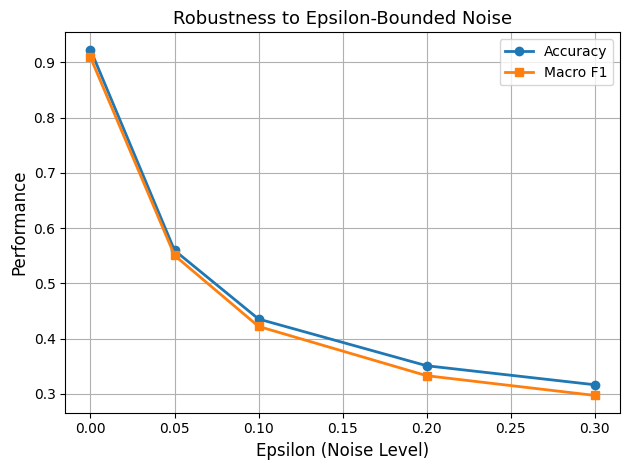

In [14]:
import matplotlib.pyplot as plt

epsilons = [0.00, 0.05, 0.10, 0.20, 0.30]
accuracies = [0.9230, 0.5598, 0.4356, 0.3511, 0.3167]
f1s =        [0.9089, 0.5507, 0.4222, 0.3331, 0.2974]

plt.plot(epsilons, accuracies, marker='o', label='Accuracy', linewidth=2)
plt.plot(epsilons, f1s, marker='s', label='Macro F1', linewidth=2)
plt.xlabel("Epsilon (Noise Level)", fontsize=12)
plt.ylabel("Performance", fontsize=12)
plt.title("Robustness to Epsilon-Bounded Noise", fontsize=13)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Adversarial Training for LightGBM

In [15]:
def add_uniform_noise(X, epsilon=0.1, seed=None):
    rng = np.random.default_rng(seed)
    noise = rng.uniform(-epsilon, epsilon, size=X.shape)
    return X + noise

# Generate adversarial samples from labeled data
epsilon_adv = 0.1
X_adv_train = add_uniform_noise(X_lab, epsilon=epsilon_adv, seed=42)
y_adv_train = y_lab.copy()

# Combine clean + adversarial
X_augmented = np.vstack([X_lab, X_adv_train])
y_augmented = np.hstack([y_lab, y_adv_train])


In [16]:
from lightgbm import LGBMClassifier

lgbm_advtrained = LGBMClassifier(verbose=-1, random_state=42, n_estimators=400, learning_rate=0.05)
lgbm_advtrained.fit(X_augmented, y_augmented)


LGBMClassifier(learning_rate=0.05, n_estimators=400, random_state=42,
               verbose=-1)

In [17]:
from sklearn.metrics import accuracy_score, f1_score

# Clean test
y_pred_clean = lgbm_advtrained.predict(X_test)
acc_clean = accuracy_score(y_test, y_pred_clean)
f1_clean = f1_score(y_test, y_pred_clean, average='macro')

# Epsilon-perturbed test
X_test_noisy = add_uniform_noise(X_test, epsilon=epsilon_adv, seed=999)
y_pred_noisy = lgbm_advtrained.predict(X_test_noisy)
acc_noisy = accuracy_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy, average='macro')

print(f"✅ Adversarially Trained LGBM (ε={epsilon_adv}):")
print(f"Clean Test → Accuracy: {acc_clean:.4f}, Macro F1: {f1_clean:.4f}")
print(f"Noisy Test → Accuracy: {acc_noisy:.4f}, Macro F1: {f1_noisy:.4f}")


✅ Adversarially Trained LGBM (ε=0.1):
Clean Test → Accuracy: 0.9144, Macro F1: 0.8995
Noisy Test → Accuracy: 0.8583, Macro F1: 0.8350


In [18]:
epsilons = [0.00, 0.05, 0.10, 0.20, 0.30]

acc_base = []
f1_base = []
acc_adv = []
f1_adv = []

for eps in epsilons:
    # Perturb test set
    X_eps = add_uniform_noise(X_test, epsilon=eps, seed=42)
    
    # Original LGBM
    y_pred_base = lgbm_ssl.predict(X_eps)
    acc_base.append(accuracy_score(y_test, y_pred_base))
    f1_base.append(f1_score(y_test, y_pred_base, average='macro'))
    
    # Adversarially trained LGBM
    y_pred_adv = lgbm_advtrained.predict(X_eps)
    acc_adv.append(accuracy_score(y_test, y_pred_adv))
    f1_adv.append(f1_score(y_test, y_pred_adv, average='macro'))


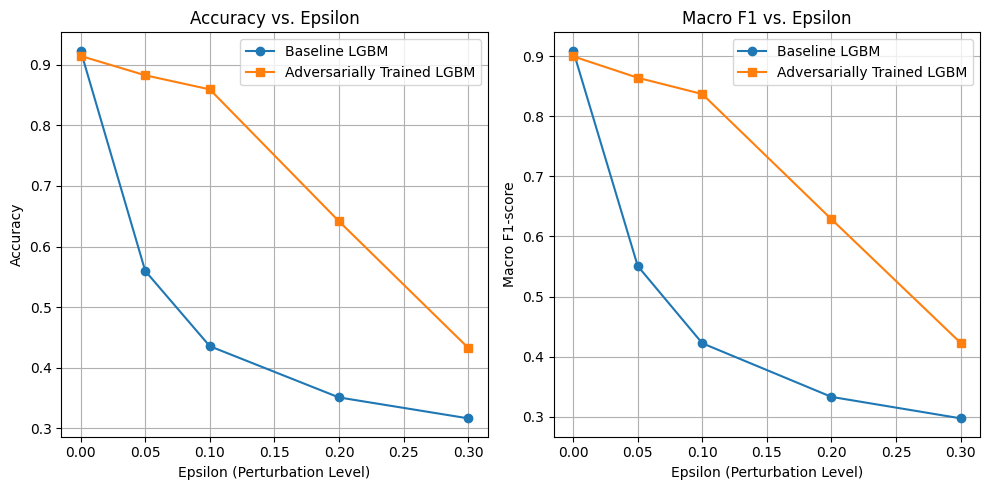

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epsilons, acc_base, 'o-', label='Baseline LGBM')
plt.plot(epsilons, acc_adv, 's-', label='Adversarially Trained LGBM')
plt.xlabel('Epsilon (Perturbation Level)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epsilon')
plt.grid(True)
plt.legend()

# F1-score plot
plt.subplot(1, 2, 2)
plt.plot(epsilons, f1_base, 'o-', label='Baseline LGBM')
plt.plot(epsilons, f1_adv, 's-', label='Adversarially Trained LGBM')
plt.xlabel('Epsilon (Perturbation Level)')
plt.ylabel('Macro F1-score')
plt.title('Macro F1 vs. Epsilon')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [20]:
print("\n📊 Robustness Evaluation Across Epsilon Levels:\n")
print(f"{'Epsilon':<10} {'Acc (Base)':<12} {'F1 (Base)':<12} {'Acc (Adv)':<12} {'F1 (Adv)':<12}")
print("-" * 60)
for eps, ab, fb, aa, fa in zip(epsilons, acc_base, f1_base, acc_adv, f1_adv):
    print(f"{eps:<10.2f} {ab:<12.4f} {fb:<12.4f} {aa:<12.4f} {fa:<12.4f}")


📊 Robustness Evaluation Across Epsilon Levels:

Epsilon    Acc (Base)   F1 (Base)    Acc (Adv)    F1 (Adv)    
------------------------------------------------------------
0.00       0.9230       0.9089       0.9144       0.8995      
0.05       0.5598       0.5507       0.8825       0.8639      
0.10       0.4356       0.4222       0.8592       0.8368      
0.20       0.3511       0.3331       0.6417       0.6286      
0.30       0.3167       0.2974       0.4330       0.4229      


# combining pseudo-labeling with adversarial training

In [21]:
# Fit base LGBM model
lgbm = LGBMClassifier(verbose=-1, random_state=42)
lgbm.fit(X_lab, y_lab)

# Predict pseudo-labels for unlabeled data
probs = lgbm.predict_proba(X_unlab)
pseudo_labels = np.argmax(probs, axis=1)
confidences = np.max(probs, axis=1)

# Filter by confidence
threshold = 0.70
mask = confidences >= threshold
X_pseudo = X_unlab[mask]
y_pseudo = pseudo_labels[mask]

epsilon = 0.1
X_lab_noisy = add_uniform_noise(X_lab, epsilon, seed=42)
X_pseudo_noisy = add_uniform_noise(X_pseudo, epsilon, seed=42)

X_all = np.vstack([
    X_lab,
    X_lab_noisy,
    X_pseudo,
    X_pseudo_noisy
])

y_all = np.hstack([
    y_lab,
    y_lab,              # same labels for noisy labeled data
    y_pseudo,
    y_pseudo            # same for noisy pseudo-labeled
])

lgbm_ssl_robust = LGBMClassifier(verbose=-1, random_state=42, n_estimators=400, learning_rate=0.05)
lgbm_ssl_robust.fit(X_all, y_all)

# Clean
y_pred_clean = lgbm_ssl_robust.predict(X_test)
acc_clean = accuracy_score(y_test, y_pred_clean)
f1_clean = f1_score(y_test, y_pred_clean, average='macro')

# Noisy
X_test_noisy = add_uniform_noise(X_test, epsilon, seed=999)
y_pred_noisy = lgbm_ssl_robust.predict(X_test_noisy)
acc_noisy = accuracy_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy, average='macro')

print("📊 Robust Semi-Supervised LGBM Evaluation:")
print(f"Clean  → Accuracy: {acc_clean:.4f}, Macro F1: {f1_clean:.4f}")
print(f"Noisy  → Accuracy: {acc_noisy:.4f}, Macro F1: {f1_noisy:.4f}")


📊 Robust Semi-Supervised LGBM Evaluation:
Clean  → Accuracy: 0.9221, Macro F1: 0.9086
Noisy  → Accuracy: 0.9003, Macro F1: 0.8826


In [22]:
epsilons = [0.00, 0.05, 0.10, 0.20, 0.30]

acc_ssl = []
f1_ssl = []
acc_ssl_robust = []
f1_ssl_robust = []

for eps in epsilons:
    X_eps = add_uniform_noise(X_test, epsilon=eps, seed=42)
    
    # Non-adversarial semi-supervised
    y_pred_ssl = lgbm_ssl.predict(X_eps)
    acc_ssl.append(accuracy_score(y_test, y_pred_ssl))
    f1_ssl.append(f1_score(y_test, y_pred_ssl, average='macro'))
    
    # Robust semi-supervised
    y_pred_ssl_robust = lgbm_ssl_robust.predict(X_eps)
    acc_ssl_robust.append(accuracy_score(y_test, y_pred_ssl_robust))
    f1_ssl_robust.append(f1_score(y_test, y_pred_ssl_robust, average='macro'))


In [23]:
print("\n📊 Semi-Supervised Robustness Evaluation:\n")
print(f"{'Epsilon':<10} {'Acc (SSL)':<12} {'F1 (SSL)':<12} {'Acc (Robust)':<14} {'F1 (Robust)':<14}")
print("-" * 60)
for eps, ab, fb, aa, fa in zip(epsilons, acc_ssl, f1_ssl, acc_ssl_robust, f1_ssl_robust):
    print(f"{eps:<10.2f} {ab:<12.4f} {fb:<12.4f} {aa:<14.4f} {fa:<14.4f}")



📊 Semi-Supervised Robustness Evaluation:

Epsilon    Acc (SSL)    F1 (SSL)     Acc (Robust)   F1 (Robust)   
------------------------------------------------------------
0.00       0.9230       0.9089       0.9221         0.9086        
0.05       0.5598       0.5507       0.9049         0.8879        
0.10       0.4356       0.4222       0.8968         0.8786        
0.20       0.3511       0.3331       0.6276         0.6276        
0.30       0.3167       0.2974       0.4244         0.4144        


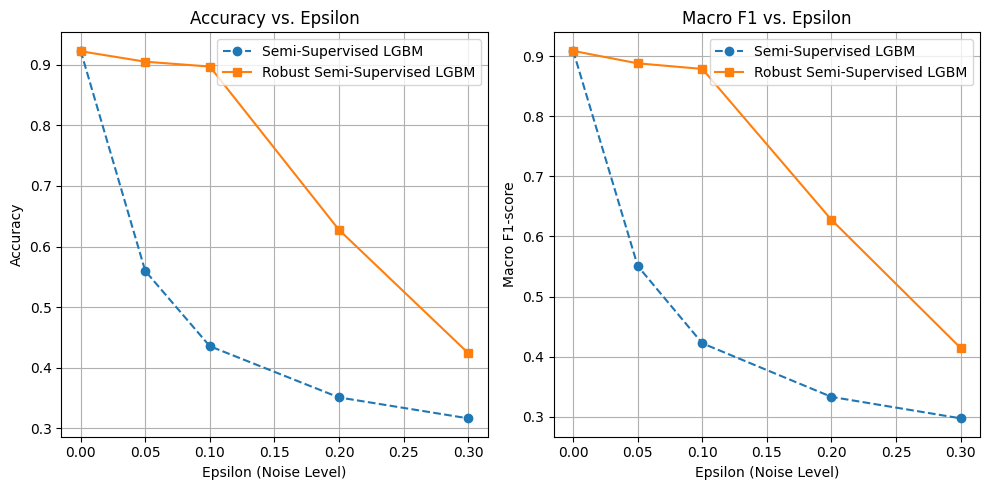

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epsilons, acc_ssl, 'o--', label='Semi-Supervised LGBM')
plt.plot(epsilons, acc_ssl_robust, 's-', label='Robust Semi-Supervised LGBM')
plt.xlabel('Epsilon (Noise Level)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epsilon')
plt.grid(True)
plt.legend()

# Macro F1 plot
plt.subplot(1, 2, 2)
plt.plot(epsilons, f1_ssl, 'o--', label='Semi-Supervised LGBM')
plt.plot(epsilons, f1_ssl_robust, 's-', label='Robust Semi-Supervised LGBM')
plt.xlabel('Epsilon (Noise Level)')
plt.ylabel('Macro F1-score')
plt.title('Macro F1 vs. Epsilon')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
